# SQL tasks
After a thorough discussion with relevant business units and project stakeholders, business questions were translated into simple & advanced SQL queries to provide answers to frequently asked questions by the different business units and relevant project stakeholders.

1. How many clients does the bank have and are above the age of 50?

2. What’s the distribution (in %) between male and female clients?

3. Let’s define a new variable called age_group:

- 10 < x ≤ 30
- 30 < x ≤ 40
- 40 < x ≤ 50
- 50 < x ≤ 60
- 60 <x ≤ 120
Per each age_group, marital_status and income_category, find out the following values:

a. Churn_rate (in %)

b. Average Total_Relationship_Count

c. Minimum value of Total_Amt_Chng_Q4_Q1

d. Count of customers

Make sure to order the data by the number of customers in descending order***

4. Out of the male clients, who are “blue” card holders, how many (in %) fall under the income category 40K - 60K?

5. Without the usage of group by at all, find the 3rd and 4th highest client IDs (CLIENTNUM’s) of Total_Amt_Chng_Q4_Q1?

6. We’re interested in knowing which client (CLIENTNUM) has the 2nd highest Total_Trans_Amt, Per each Marital_Status.

The bank wanted to create a dedicated campaign to target these specific clients moving forward. So my task in this section was to help the bank find those clients.

See Customer Churn ERD below


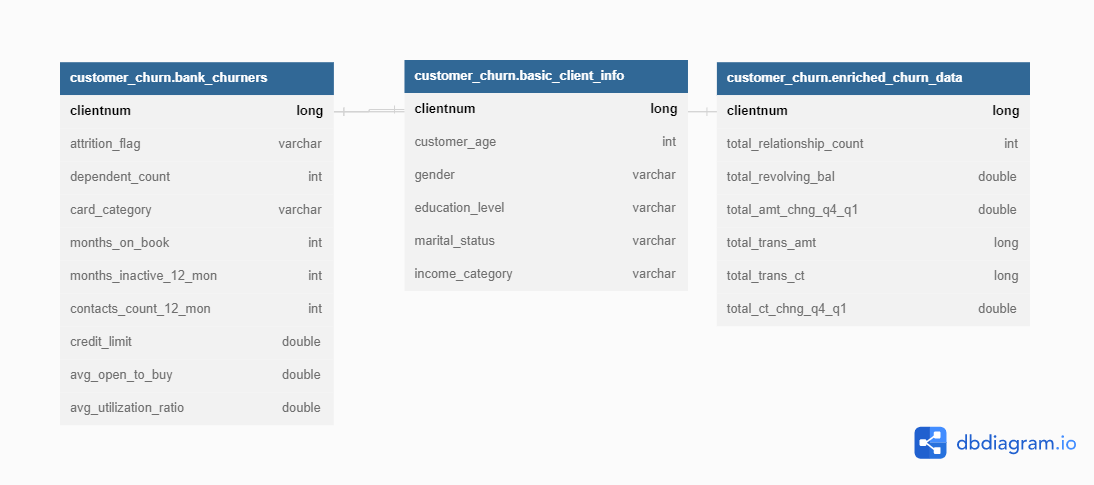

**Question 1:**

How many clients does the bank have and are above the age of 50?

In [6]:
import sqlite3
import pandas as pd

# Load CSV
df = pd.read_csv("basic_client_info.csv")

# Create in-memory SQLite DB
conn = sqlite3.connect(":memory:")
df.to_sql("basic_client_info", conn, index=False, if_exists="replace")

# Run query
query = """
SELECT COUNT(*) AS clients_above_50
FROM basic_client_info
WHERE "Customer Age" > 50
"""
result = pd.read_sql(query, conn)
print(result)


   clients_above_50
0             10127


**Question 2:**

What’s the distribution (in %) between male and female clients?

In [7]:
query = """
WITH total_count AS (
    SELECT COUNT(*) AS total
    FROM basic_client_info
)
SELECT
  Gender,
  ROUND(COUNT(*) * 100.0 / total, 1) AS percent_distribution
FROM basic_client_info, total_count
GROUP BY Gender, total
"""
result = pd.read_sql(query, conn)
print(result)


  gender  percent_distribution
0      F                  52.9
1      M                  47.1


**Question 3:**

Per each age_group, marital_status and income_category, find out the following values:

a. Churn_rate (in %)

b. Average Total_Relationship_Count

c. Minimum value of Total_Amt_Chng_Q4_Q1

d. Count of customers

(Make sure to order the data by the number of customers in descending order)

In [8]:
query = """
SELECT
    CLIENTNUM,
    CASE
        WHEN "Customer Age" > 10 AND "Customer Age" <= 30 THEN '11 - 30'
        WHEN "Customer Age" > 30 AND "Customer Age" <= 40 THEN '31 - 40'
        WHEN "Customer Age" > 40 AND "Customer Age" <= 50 THEN '41 - 50'
        WHEN "Customer Age" > 50 AND "Customer Age" <= 60 THEN '51 - 60'
        WHEN "Customer Age" > 60 AND "Customer Age" <= 120 THEN '61 - 120'
    END AS age_group,
    Marital_Status,
    Income_Category
FROM basic_client_info
"""
demographics = pd.read_sql(query, conn)
print(demographics.head())

   clientnum age_group marital_status income_category
0  708082083      None        Married  Less than $40K
1  708083283      None         Single     $40K - $60K
2  708084558      None       Divorced    $80K - $120K
3  708085458      None         Single  Less than $40K
4  708086958      None        Married         Unknown


In [29]:
import pandas as pd

# Load datasets
basic = pd.read_csv("basic_client_info.csv")
bank = pd.read_csv("bankchurners.csv")
enriched = pd.read_csv("enriched_churn_data.csv")

# --- Recreate demographics "view" ---
bins = [10, 30, 40, 50, 60, 120]
labels = ["11 - 30", "31 - 40", "41 - 50", "51 - 60", "61 - 120"]
basic["age_group"] = pd.cut(basic["customer_age"], bins=bins, labels=labels, right=True)

demographics = basic[["clientnum", "age_group", "marital_status", "income_category"]]

# --- Join datasets ---
merged = demographics.merge(bank, on="clientnum") \
                     .merge(enriched, on="clientnum")

# --- Add churn flag ---
merged["is_churned"] = merged["attrition_flag"].apply(lambda x: 1 if x == "Attrited Customer" else 0)

# --- Pivot / Group summary ---
summary = merged.groupby(["age_group", "marital_status", "income_category"]).agg(
    churn_rate_percent=("is_churned", lambda x: round(100 * x.sum() / len(bank), 1)),
    avg_total_product_count=("total_relationship_count", "mean"),
    min_amt_chng_q4_q1=("total_amt_chng_q4_q1", "min"),
    client_count=("clientnum", "count")
).reset_index()

# Round product count like SQL
summary["avg_total_product_count"] = summary["avg_total_product_count"].round()

# Order like SQL
summary = summary.sort_values(by=["age_group", "client_count"], ascending=[True, False])

print(summary.head())


   age_group marital_status income_category  churn_rate_percent  \
16   11 - 30         Single  Less than $40K                 0.1   
10   11 - 30        Married  Less than $40K                 0.0   
13   11 - 30         Single     $40K - $60K                 0.0   
17   11 - 30         Single         Unknown                 0.0   
4    11 - 30       Divorced  Less than $40K                 0.0   

    avg_total_product_count  min_amt_chng_q4_q1  client_count  
16                      4.0               0.299            69  
10                      4.0               0.549            36  
13                      4.0               0.331            29  
17                      4.0               0.391            27  
4                       4.0               0.632            16  


/tmp/ipython-input-2213638982.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = merged.groupby(["age_group", "marital_status", "income_category"]).agg(


**Question 4:**

Out of the male clients, who holds the “blue” card, how many (in %) hold the income category 40K - 60K?

In [21]:
import sqlite3
import pandas as pd

# Load CSVs
basic = pd.read_csv("basic_client_info.csv")
bank = pd.read_csv("bankchurners.csv")

# Create SQLite DB
conn = sqlite3.connect(":memory:")
basic.to_sql("basic_client_info", conn, index=False, if_exists="replace")
bank.to_sql("bankchurners", conn, index=False, if_exists="replace")

query = """
WITH total_count AS (
    SELECT COUNT(*) AS total
    FROM basic_client_info AS bci
    JOIN bankchurners AS bc
        ON bci.CLIENTNUM = bc.CLIENTNUM
    WHERE Gender = 'M'
      AND Card_Category = 'Blue'
),
male_blue_card_holders AS (
    SELECT Income_Category
    FROM basic_client_info AS bci
    JOIN bankchurners AS bc
        ON bci.CLIENTNUM = bc.CLIENTNUM
    WHERE Gender = 'M'
      AND Card_Category = 'Blue'
)
SELECT
    Income_Category,
    ROUND(100.0 * COUNT(Income_Category) / total, 2) AS percent_of_male_blue_card_holders
FROM male_blue_card_holders, total_count
GROUP BY Income_Category, total
LIMIT 1 OFFSET 3
"""
result = pd.read_sql(query, conn)
print(result)


  Income_Category  percent_of_male_blue_card_holders
0    $80K - $120K                              32.18


**Question 5:**

Without the usage of group by at all, find the 3rd and 4th highest client IDs (CLIENTNUM’s) of Total_Amt_Chng_Q4_Q1?

In [22]:
import sqlite3
import pandas as pd

# Load CSV
enriched = pd.read_csv("enriched_churn_data.csv")

# Create SQLite DB
conn = sqlite3.connect(":memory:")
enriched.to_sql("enriched_churn_data", conn, index=False, if_exists="replace")

# Run query
query = """
SELECT CLIENTNUM
FROM enriched_churn_data
ORDER BY Total_Amt_Chng_Q4_Q1 DESC
LIMIT 2 OFFSET 2
"""
result = pd.read_sql(query, conn)
print(result)


   clientnum
0  713989233
1  713982108


**Question 6:**

We’re interested in knowing which client (CLIENTNUM) has the 2nd highest Total_Trans_Amt, Per each Marital_Status.

In [23]:
import sqlite3
import pandas as pd

# Load CSVs
basic = pd.read_csv("basic_client_info.csv")
enriched = pd.read_csv("enriched_churn_data.csv")

# Create SQLite DB
conn = sqlite3.connect(":memory:")
basic.to_sql("basic_client_info", conn, index=False, if_exists="replace")
enriched.to_sql("enriched_churn_data", conn, index=False, if_exists="replace")

# Query using ROW_NUMBER()
query = """
WITH ranked AS (
    SELECT
        bci.CLIENTNUM,
        Marital_Status,
        Total_Trans_Amt,
        ROW_NUMBER() OVER (PARTITION BY Marital_Status ORDER BY Total_Trans_Amt DESC) AS rnk
    FROM basic_client_info AS bci
    JOIN enriched_churn_data AS ecd
        ON bci.CLIENTNUM = ecd.CLIENTNUM
)
SELECT
    Marital_Status,
    CLIENTNUM AS client_with_2nd_highest_trans_amt
FROM ranked
WHERE rnk = 2
"""
result = pd.read_sql(query, conn)
print(result)


  Marital_Status  client_with_2nd_highest_trans_amt
0       Divorced                          716894658
1        Married                          717642633
2         Single                          716004258
3        Unknown                          719848008
